# Computer Vision Lab

### Load MNIST (modified NIST dataset)

http://yann.lecun.com/exdb/mnist/

*"The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image."*


@misc{TFDS,
  title = { {TensorFlow Datasets}, A collection of ready-to-use datasets},
  howpublished = {\url{https://www.tensorflow.org/datasets}},
}


> Following example by https://gist.github.com/datlife/abfe263803691a8864b7a2d4f87c4ab8

In [ ]:
### Import packages and functions
import tensorflow as tf   # only work from tensorflow==1.9.0-rc1 and after
from tensorflow.keras.layers import Conv2D, MaxPool2D, AvgPool2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.layers import Conv3D, MaxPool3D
print(tf.__version__)

In [ ]:
def tfdata_generator(images, labels, is_training, batch_size=128):
    '''Construct a data generator using tf.Dataset'''

    def preprocess_fn(image, label):
        '''A transformation function to preprocess raw data
        into trainable input. '''
        
        
        x = tf.reshape(tf.cast(image, tf.float32), (28, 28, 1))
        
        ## The input shape for the convolutional neural network is 32 by definition of the LeNet,
        ## to ensure that the figure is centered in the middle of the frame. (LeCun et. al 1998)
        ## To solve this issues we use a standar procedure called padding
        
        ## Use tf.pad for padding images to required input (32,32,1)\n",
        ## START CODE HERE ~ 2 lines of code
        
        y = tf.one_hot(tf.cast(label, tf.uint8), _NUM_CLASSES)
        return x, y

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_training:
        dataset = dataset.shuffle(1000)  # depends on sample size

    # Transform and batch data at the same time
    dataset = tf.data.Dataset.map(dataset,
        preprocess_fn,
        num_parallel_calls=4  # cpu cores
        )
    
    dataset = dataset.repeat()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

# LeNet 5 
Le Cunn et. al 1998


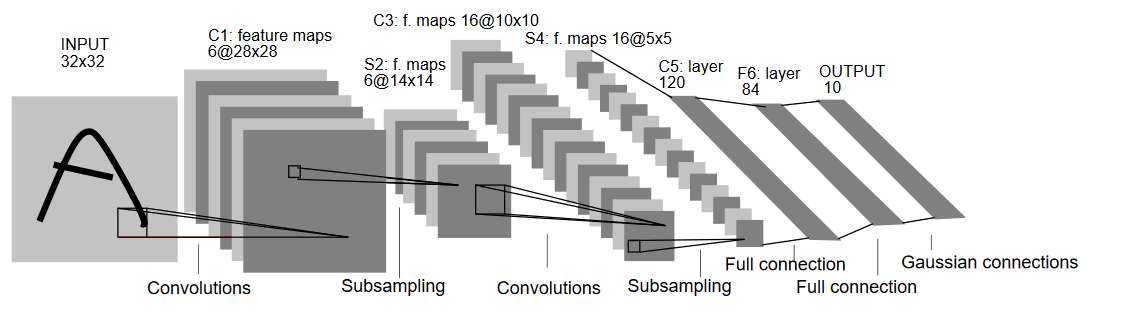

This image is Figure 2 in Le Cunn et al. 1998 (PROC. of the IEEE) Gradient-Based Learning Applied to Document Recognition

The development of the example has been inspired by the original paper (Le Cunn et al. 1998) and the medium article:

### LeNet-5 in 9 lines of code using Keras Keras is a high-level open source APIs, written in Python and capable of running on top of TensorFlow, Microsoft’s CNTK, or Theano
> https://medium.com/@mgazar/lenet-5-in-9-lines-of-code-using-keras-ac99294c8086

Mostafa Gazar (Nov 26, 2018)

In [ ]:
def keras_model():

    inputs = Input(shape=(32, 32, 1))
    x = Conv2D(filters = 6, kernel_size=(5, 5),
               activation='relu', padding='valid')(inputs)
    
    ## For the subsampling, LeCunn used to add the values and multiply by a training parameter,
    ## using the Avg Pool is like adding and multiplying per 1/N
    
    ## Complete the model with LeCunn et al 1998 indications: add a Pooling layer
    ## with neighborhood of 2 cells
    ## a Conv2D layer with 16 filters and kernel size 5 and activation ReLu, 
    ## another pooling layer with neigh. of 2 and another convolutional 
    ## with kernel size 5 and 120 filters, again use ReLu
    ## START CODE HERE ~ 4 lines of code
    
    x = Flatten()(x)
#     x = Dense(120, activation='relu')(x)
    x = Dense(84, activation='tanh')(x)
    
    outputs = Dense(10, activation='softmax')(x)

    return tf.keras.Model(inputs, outputs)

In [ ]:
# parameter definition
_EPOCHS      = 20
_NUM_CLASSES = 10
_BATCH_SIZE  = 128

In [ ]:
# #############
# Load Dataset
# #############
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
training_set = tfdata_generator(x_train, y_train, is_training=True, batch_size=_BATCH_SIZE)
testing_set  = tfdata_generator(x_test, y_test, is_training=False, batch_size=_BATCH_SIZE)

# #############
# Train Model
# #############
model = keras_model()  # your keras model here
model.summary()
model.compile('adam', 'categorical_crossentropy', metrics=['acc'])

model.fit(
  training_set.batch(_BATCH_SIZE),
  steps_per_epoch=len(x_train) // _BATCH_SIZE,
  epochs=_EPOCHS,
  validation_data=testing_set.batch(_BATCH_SIZE),
  validation_steps=len(x_test) // _BATCH_SIZE,
  verbose = 1)
score = model.evaluate(testing_set.batch(_BATCH_SIZE),
                       steps=len(x_test) // _BATCH_SIZE)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


In [ ]:
from keras.utils import plot_model
plot_model(model)

In [ ]:
import matplotlib.pyplot as plt

History = model.history
# Plot training & validation accuracy values
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("lenet5.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("lenet5.h5")
print("Saved model to disk")
 
# later...
from tensorflow.keras.models import model_from_json
# load json and create model
json_file = open('lenet5.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("lenet5.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

score = model.evaluate(testing_set.batch(_BATCH_SIZE),
                       steps=len(x_test) // _BATCH_SIZE)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


# AlexNet
Alex Krizhevsky et. al 2012


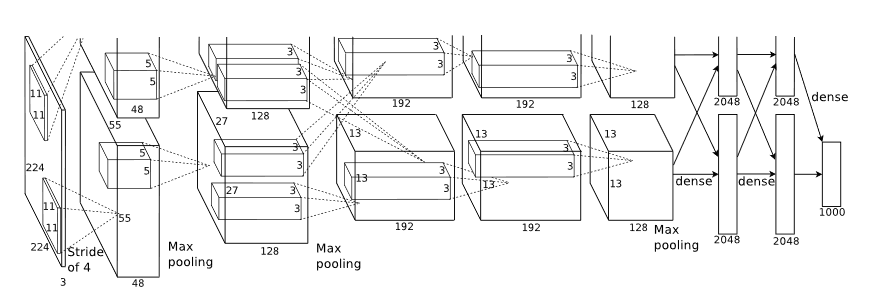

This image is Figure 2 in Alex Krizhevsky et. al 2012(NIPS Proceedings) ImageNet Classification with Deep ConvolutionalNeural Networks

In [ ]:
def tfdata_generator(images, labels, is_training, batch_size=128):
    '''Construct a data generator using tf.Dataset'''

    def preprocess_fn(image, label):
        '''A transformation function to preprocess raw data
        into trainable input. '''
        
        
        x = tf.reshape(tf.cast(image, tf.float32), (28, 28, 1))
        
        ## The input shape for the convolutional neural network is 32 by definition of the LeNet,
        ## to ensure that the figure is centered in the middle of the frame. (LeCun et. al 1998)
        ## To solve this issues we use a standar procedure called padding
        
        ## Use tf.pad for padding images to required input (32,32,1)\n",
        ## START CODE HERE ~ 2 lines of code
        
        ## Transform white and black into RGB 
        ## START CODE HERE ~ 1 line of code

        
        y = tf.one_hot(tf.cast(label, tf.uint8), _NUM_CLASSES)
        return x, y

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_training:
        dataset = dataset.shuffle(1000)  # depends on sample size

    # Transform and batch data at the same time
    dataset = tf.data.Dataset.map(dataset,
        preprocess_fn,
        num_parallel_calls=4  # cpu cores
        )
    
    dataset = dataset.repeat()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

In [ ]:
def keras_model():

    inputs = Input(shape=(224, 224, 3))
    
    # 1st Convolutional Layer
    
    ## START CODE HERE
    ## ADD CONV 96 filters, ReLu, kernel size 11 and stride of 4
    

    # Pooling 
    ## The author decides to use an overlapping pool 
    
    ## START CODE HERE
    ## ADD max pool  of neigh 3 and stride 2
    # ADD Batch Normalisation before passing it to the next layer
    

    # 2nd Convolutional Layer
    ## START CODE HERE
    ## ADD CONV 256 filters, ReLu, kernel size 5 and no stride
    

    # Pooling 
    ## START CODE HERE
    ## ADD max pool  of neigh 3 and stride 2
    # ADD Batch Normalisation 
    

    # 3rd Convolutional Layer
    ## START CODE HERE
    ## ADD CONV 384 filters, ReLu, kernel size 3 and no stride
    
    # 4th Convolutional Layer

    ## ADD CONV 384 filters, ReLu, kernel size 3 and no stride
    
    # 5th Convolutional Layer
    ## ADD CONV 256 filters, ReLu, kernel size 3 and no stride


    # Pooling 
    ## START CODE HERE
    ## ADD max pool  of neigh 3 and stride 2
    # ADD Batch Normalisation 
    
    
    # Passing it to a dense layer
    x = Flatten()(x)
    # 1st Dense Layer
    x = Dense(4096, activation='relu')(x)
    
    # Add Dropout to prevent overfitting
    x = Dropout(0.5)(x)
    # Batch Normalisation
    x = BatchNormalization()(x)

    # 2nd Dense Layer
    x = Dense(4096, activation = 'relu')(x)
    # Batch Normalisation
    x = BatchNormalization()(x)

    # 3rd Dense Layer
    x = Dense(1000, activation = 'relu')(x)
    # Batch Normalisation
    x = BatchNormalization()(x)

    # Output Layer
    outputs = Dense(10, activation = 'softmax')(x)

    return tf.keras.Model(inputs, outputs)

In [ ]:
# parameter definition
_EPOCHS      = 5
_NUM_CLASSES = 10
_BATCH_SIZE  = 128

In [ ]:
# #############
# Load Dataset
# #############
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
training_set = tfdata_generator(x_train, y_train, is_training=True, batch_size=_BATCH_SIZE)
testing_set  = tfdata_generator(x_test, y_test, is_training=False, batch_size=_BATCH_SIZE)

# #############
# Train Model
# #############
model = keras_model()  # your keras model here
model.summary()
model.compile('adam', 'categorical_crossentropy', metrics=['acc'])

model.fit(
  training_set.batch(_BATCH_SIZE),
  steps_per_epoch=len(x_train) // _BATCH_SIZE,
  epochs=_EPOCHS,
  validation_data=testing_set.batch(_BATCH_SIZE),
  validation_steps=len(x_test) // _BATCH_SIZE,
  verbose = 1)
score = model.evaluate(testing_set.batch(_BATCH_SIZE),
                       steps=len(x_test) // _BATCH_SIZE)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


In [ ]:
from keras.utils import plot_model
plot_model(model)

In [ ]:
import matplotlib.pyplot as plt

History = model.history
# Plot training & validation accuracy values
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Save the model since it takes 15h to train

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("alexnet.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("alexnet.h5")
print("Saved model to disk")
 

In [ ]:
# later...
 
# load json and create model
json_file = open('alexnet.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("alexnet.h5")
print("Loaded model from disk")


In [ ]:
score = model.evaluate(testing_set.batch(_BATCH_SIZE),
                       steps=len(x_test) // _BATCH_SIZE)
print('Test loss:', score[0])
print('Test accuracy:', score[1])